In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image
import torch
from torchvision import datasets, models, transforms
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
import torchvision
from torch.autograd import Variable
import time
import copy

input_path = "../input/data-chamber/DATA_CHAMBER_2021/" 
use_gpu = torch.cuda.is_available()
if use_gpu:
    print("Using CUDA")
    

Using CUDA


In [2]:
import os
from os import listdir, makedirs, getcwd, remove
from os.path import join, exists, expanduser

cache_dir = expanduser(join('~', '.torch'))

if not exists(cache_dir):
    makedirs(cache_dir)
models_dir = join(cache_dir, 'models')
if not exists(models_dir):
    makedirs(models_dir)
    
!cp ../input/pretrained-pytorch-models/* ~/.torch/models/
!ls ~/.torch/models

densenet161-17b70270.pth	  resnet50-19c8e357.pth
inception_v3_google-1a9a5a14.pth  squeezenet1_0-a815701f.pth
resnet18-5c106cde.pth		  squeezenet1_1-f364aa15.pth


In [3]:
class ImageFolderWithPaths(datasets.ImageFolder):
    """Custom dataset that includes image file paths. Extends
    torchvision.datasets.ImageFolder
    """

    # override the __getitem__ method. this is the method that dataloader calls
    def __getitem__(self, index):
        # this is what ImageFolder normally returns 
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        # the image file path
        path = self.imgs[index][0]
        # make a new tuple that includes original and the path
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path

In [4]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [5]:
def initialize_model(model_name, num_classes, feature_extract = False, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "resnet":
        """ Resnet18
        """
        model_ft = models.resnet18(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "alexnet":
        """ Alexnet
        """
        model_ft = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "vgg":
        """ VGG11_bn
        """
        model_ft = models.vgg19_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "squeezenet":
        """ Squeezenet
        """
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes
        input_size = 224

    elif model_name == "densenet":
        """ Densenet
        """
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "inception":
        """ Inception v3
        Be careful, expects (299,299) sized images and has auxiliary output
        """
        model_ft = models.inception_v3(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        # Handle the auxilary net
        num_ftrs = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        # Handle the primary net
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs,num_classes)
        input_size = 299

    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size

# Initialize the model for this run
model_ft, input_size = initialize_model('inception', 3, use_pretrained=True)

# Print the model we just instantiated
#print(model_ft)

In [6]:


data_transforms = {
    'train': transforms.Compose([   # Here we do not make data augmentations
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size), # Note that we want to use Inception v3, it requires this size of images
        transforms.ToTensor(),
        #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # We can simply use this parameter
    ]),
    'validation': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}



image_datasets = {
    'train': 
    ImageFolderWithPaths(input_path + 'train', data_transforms['train']),
    'validation': 
    ImageFolderWithPaths(input_path + 'test', data_transforms['validation'])
}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train','validation']}

dataloaders = {
    'train':
    torch.utils.data.DataLoader(image_datasets['train'],
                                batch_size=8,
                                shuffle=True,
                                num_workers=1),  # for Kaggle
    'validation':
    torch.utils.data.DataLoader(image_datasets['validation'],
                                batch_size=8,
                                shuffle=True,
                                num_workers=1)  # for Kaggle
}
class_names = image_datasets['train'].classes

# See some statistics
print(dataloaders)
len(dataloaders['train'])

{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4388a8d4e0>, 'validation': <torch.utils.data.dataloader.DataLoader object at 0x7f4388a8d4a8>}


840

### Visualize a few images

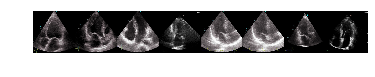

In [7]:
import numpy as np
import matplotlib.pyplot as plt
plt.ion()   # interactive mode

# def imshow(inp, title=None):
#     """Imshow for Tensor."""
#     inp = inp.numpy().transpose((1, 2, 0))
#     mean = np.array([0.485, 0.456, 0.406])
#     std = np.array([0.229, 0.224, 0.225])
#     inp = std * inp + mean
#     inp = np.clip(inp, 0, 1)
#     plt.imshow(inp)
#     if title is not None:
#         plt.title(title)
#     plt.pause(0.001)  # pause a bit so that plots are updated

def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    # plt.figure(figsize=(10, 10))
    plt.axis('off')
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)


# Get a batch of training data
inputs, classes,_ = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out)

# imshow(out, title=[class_names[x] for x in classes])

## 2. General functions to train and visualize

Here we use a general function to train a model. It includes:

* Scheduling the learning rate
* Saving the best model

We use [*torch.optim.lr_scheduler*](https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate). It provides several methods to adjust the learning rate based on the number of epochs. Our function parameter `scheduler` is an object from it.

In [8]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=2, is_inception=False):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'validation']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels,_ in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    # mode we calculate the loss by summing the final output and the auxiliary output
                    # but in testing we only consider the final output.
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)
                    
                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                del inputs,labels,

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'validation' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

### Visualizing the model predictions

A generic function to display predictions for a few images.

In [9]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels,_) in enumerate(dataloaders['validation']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

## 3. Transfer learning: feature extractor

Here we use **Inception v3** as a fixed feature extractor.

Here, we need to freeze all the network except the final layer. We need to set `requires_grad == False` to freeze the parameters so that the gradients are not computed in `backward()`.

### Inception v3

Inception v3 was first described in [Rethinking the Inception Architecture for Computer Vision](https://arxiv.org/pdf/1512.00567v1.pdf). This network is unique because it has two output layers when training. 

The second output is known as an auxiliary output and is contained in the AuxLogits part of the network. The primary output is a linear layer at the end of the network. 

Note, when testing we only consider the primary output. 

## 4. Train and evaluate

We use [torch.optim.lr_scheduler.StepLR](https://pytorch.org/docs/stable/optim.html#torch.optim.lr_scheduler.StepLR) to schedule the learning rate.

In [10]:

def test_model(model, criterion, optimizer):
    labels_input=list()
    labels_output=list()
    vid_id = list()
    for phase in ['validation']:
        model.eval()

        running_loss = 0.0
        running_corrects = 0

        for inputs, labels, fname in dataloaders[phase]:
            inputs = inputs.to(device)
            labels = labels.to(device)
            labels_input= labels_input + labels.tolist()
            for f in fname:
                vid_id.append(f.split('/')[-1].split('.')[0].split('_')[0])
            outputs = model(inputs)
            
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)
            
            labels_output= labels_output + preds.tolist()
    return labels_input,labels_output,vid_id
            
# y_true,y_pred,vid_id = test_model(model, criterion, optimizer)

In [11]:
from torch.optim import lr_scheduler

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model_ft = model_ft.to(device)

# Observe that only parameters of final layer are being optimized as
# opposed to before.
params_to_update = []
for name,param in model_ft.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)

optimizer_conv = optim.SGD(params_to_update, lr=0.01, momentum=0.9)

criterion = nn.CrossEntropyLoss()
# Decay LR by a factor of 0.1 every epoch
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=1, gamma=0.1)

In [12]:
model_ft = train_model(model_ft, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=7, is_inception=True) # As an example, only show the results of 2 epoch

Epoch 1/7
----------
train Loss: 0.3127 Acc: 0.9241
validation Loss: 0.1307 Acc: 0.9540

Epoch 2/7
----------
train Loss: 0.0100 Acc: 0.9991
validation Loss: 0.1087 Acc: 0.9695

Epoch 3/7
----------
train Loss: 0.0095 Acc: 0.9994
validation Loss: 0.1063 Acc: 0.9683

Epoch 4/7
----------
train Loss: 0.0048 Acc: 0.9993
validation Loss: 0.1126 Acc: 0.9652

Epoch 5/7
----------
train Loss: 0.0039 Acc: 0.9996
validation Loss: 0.1142 Acc: 0.9664

Epoch 6/7
----------
train Loss: 0.0044 Acc: 1.0000
validation Loss: 0.1233 Acc: 0.9652

Epoch 7/7
----------
train Loss: 0.0047 Acc: 0.9997
validation Loss: 0.1112 Acc: 0.9664

Training complete in 13m 51s
Best val Acc: 0.969508


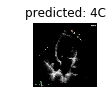

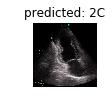

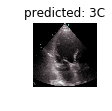

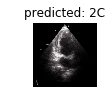

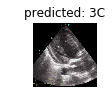

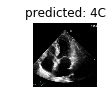

In [13]:
visualize_model(model_ft)

plt.ioff()
plt.show()

In [14]:
y_true,y_pred,vid_id = test_model(model_ft, criterion, optimizer_conv)


In [15]:
from sklearn.metrics import accuracy_score
accuracy_score(y_true,y_pred)

0.9695084007467331

In [16]:
import pandas as pd
import glob


df = pd.DataFrame(list(zip(y_true,y_pred,vid_id)),columns =['y_true','y_pred','vid_id'])
df.to_csv('df.csv',encoding='utf-8',index=False)

vid_list = list(set(df['vid_id'].values))
y_true = []
y_pred = []
for vid in vid_list:
    #print(vid)
    tmp_df = df[df['vid_id']==vid]
    #print(len(tmp_df))
    vid_pred = tmp_df['y_pred'].mode().values[0]
    vid_label = tmp_df['y_true'].mode().values[0]
    y_true.append(vid_label)
    y_pred.append(vid_pred)
    #print(vid_label,"\n",vid_pred)
    
    #print('vid: {} label: {} pred: {}'.format(vid,vid_label,vid_pred))

In [17]:
accuracy_score(y_true,y_pred)

0.9743589743589743